# Random Forest Modelling Notebook for LAQN

- Starting ML, very excited.
- This notebook is for Random Forest training using 2D flattened data.
- Inputs will be taken from: `data/laqn/ml_prep` folder.
- I will be using Géron's *Hands-On Machine Learning with Scikit-Learn, Keras and TensorFlow* 3rd edition as primary source to understand the X_training and y sets better and clear implementation structures mirroring from the book.

---

## What this notebook does

1. Load prepared data from ml_prep output.
2. Understand the X and y structure (following Géron Chapter 2).
3. Train a baseline Random Forest model.
4. Evaluate using RMSE, MAE, R² (Géron Chapter 2 evaluation approach).
5. Fine-tune hyperparameters with GridSearchCV (Géron Chapter 2).
6. Analyse feature importance.
7. Save the trained model.

---

## Why Random Forest?

From Géron (2023, Chapter 7), Random Forest is an ensemble of Decision Trees trained on different random subsets of the training data. Each tree votes on the prediction, and the final output is the average (for regression) or majority vote (for classification).

Key advantages for air quality prediction:
- Handles nonlinear relationships without feature scaling.
- Provides feature importance for interpretability.
- Robust against overfitting when properly tuned.
- Works well with tabular data like our flattened time series.

In [41]:
# mandatory libraries for random forest training

import numpy as np
import pandas as pd
import joblib
import os
from pathlib import Path
import time

# scikit-learn for random forest and evaluation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

#before grid search, I decided to use kfol n_splits =5
from sklearn.model_selection import KFold

# modules for ebaluation metrics - scikit-learn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


#gridsearch for 6 sections
from sklearn.model_selection import GridSearchCV


# visualisation
import matplotlib.pyplot as plt

### File paths

Loading from the ml_prep output folder where all prepared arrays are saved.

In [21]:
#Paths setup matching ml_prep output 
base_dir = Path.cwd().parent.parent / "data" / "laqn"
ml_prep_dir = base_dir / "ml_prep"

#Output folder for this notebook
rf_output_dir = base_dir / "rf_model"
rf_output_dir.mkdir(parents=True, exist_ok=True)

print(f"Loading data from: {ml_prep_dir}")
print(f"Saving results to: {rf_output_dir}")

Loading data from: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/ml_prep
Saving results to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/rf_model


## 1) Load prepared data

The ml_prep notebook created:
- `X_train_rf.npy`: Flattened training features (9,946 samples × 468 features)
- `X_val_rf.npy`: Flattened validation features (2,131 samples × 468 features)
- `X_test_rf.npy`: Flattened test features (2,132 samples × 468 features)
- `y_train.npy`, `y_val.npy`, `y_test.npy`: Target values
- `rf_feature_names.joblib`: Feature names for interpretability
- `scaler.joblib`: MinMaxScaler to reverse normalisation

The flattening was necessary because Random Forest expects 2D input (samples, features), but the original sequences were 3D (samples, timesteps, features).

In [22]:
# load all prepared data
print("Loading data")

X_train = np.load(ml_prep_dir / "X_train_rf.npy")
X_val = np.load(ml_prep_dir / "X_val_rf.npy")
X_test = np.load(ml_prep_dir / "X_test_rf.npy")

y_train = np.load(ml_prep_dir / "y_train.npy")
y_val = np.load(ml_prep_dir / "y_val.npy")
y_test = np.load(ml_prep_dir / "y_test.npy")

rf_feature_names = joblib.load(ml_prep_dir / "rf_feature_names.joblib")
feature_names = joblib.load(ml_prep_dir / "feature_names.joblib")
scaler = joblib.load(ml_prep_dir / "scaler.joblib")


Loading data


In [12]:
#check loaded data shapes

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Number of RF features: {len(rf_feature_names)}")
print(f"Number of target features: {len(feature_names)}")

X_train shape: (9946, 468)
X_val shape: (2131, 468)
X_test shape: (2132, 468)
y_train shape: (9946, 39)
y_val shape: (2131, 39)
y_test shape: (2132, 39)
Number of RF features: 468
Number of target features: 39


    X_train shape: (9946, 468)
    X_val shape: (2131, 468)
    X_test shape: (2132, 468)
    y_train shape: (9946, 39)
    y_val shape: (2131, 39)
    y_test shape: (2132, 39)
    Number of RF features: 468
    Number of target features: 39

## 2) Select target pollutant

The y array has 39 outputs (one for each feature). For better evaluation, I will train a single-output model first.

### Why single-output?

Starting with one target keeps things simple:
- Easier to interpret evaluation metrics (RMSE, R² for one pollutant).
- Easier to understand feature importance (what predicts NO2 specifically).
- Can train separate models for PM10 and O3 later and compare.

### Which target to select?

In ml_prep notebook section 6.A, I selected 35 columns sorted by data coverage. The first column has the highest coverage, making it the most reliable target for initial training.

In [23]:
# list targets
print("Available targets:")
for i, name in enumerate(feature_names):
    print(f"  {i:2d}: {name}")

Available targets:
   0: EN5_NO2
   1: WMD_NO2
   2: BT5_NO2
   3: HP1_PM10
   4: EN1_NO2
   5: ME9_NO2
   6: BT6_NO2
   7: BT8_PM10
   8: HV1_NO2
   9: BT4_PM10
  10: KC1_NO2
  11: BT8_NO2
  12: EI1_NO2
  13: HP1_NO2
  14: BX2_PM10
  15: GN0_NO2
  16: WM6_NO2
  17: IS6_NO2
  18: RI1_NO2
  19: HP1_O3
  20: BT6_PM10
  21: SK5_NO2
  22: BX1_O3
  23: GR9_NO2
  24: EN4_NO2
  25: GN6_NO2
  26: GR7_PM10
  27: KC1_O3
  28: GR7_NO2
  29: GN3_PM10
  30: LB4_NO2
  31: GN4_PM10
  32: GN4_NO2
  33: EA8_NO2
  34: EA6_NO2
  35: hour
  36: day_of_week
  37: month
  38: is_weekend


In [24]:
# select EN5_NO2
target_idx= 0
target_name = feature_names[target_idx]

y_train_single = y_train[:, target_idx]
y_val_single = y_val[:, target_idx]
y_test_single = y_test[:, target_idx]

print(f"Target: {target_idx}")
print(f"y_train_single: {y_train_single.shape}")
print(f"Range: [{y_train_single.min():.4f}, {y_train_single.max():.4f}]")

Target: 0
y_train_single: (9946,)
Range: [0.0079, 1.0000]


    Target: 0
    y_train_single: (9946,)
    Range: [0.0079, 1.0000]


## 3) Train baseline model (Géron Chapter 7)

From Géron (2023, Chapter 7 - Ensemble Learning and Random Forests):

> "A random forest is an ensemble of decision trees, generally trained via the bagging method (or sometimes pasting), typically with `max_samples` set to the size of the training set. Instead of building a `BaggingClassifier` and passing it a `DecisionTreeClassifier`, you can use the `RandomForestClassifier` class, which is more convenient and optimized for decision trees (similarly, there is a `RandomForestRegressor` class for regression tasks)."

Since I am predicting continuous pollution values (regression), I use `RandomForestRegressor`.

### Key parameters:

| Parameter | Default | What it does |
| --- | --- | --- |
| n_estimators | 100 | Number of trees in the forest |
| max_leaf_nodes | None | Maximum leaf nodes per tree |
| n_jobs | -1 | CPU cores to use (-1 = all available) |
| random_state | 42 | Seed for reproducibility |

Géron's example uses `n_estimators=500` and `max_leaf_nodes=16`, but I start with defaults to establish a baseline before tuning.

In [25]:
# train baseline Random Forest
# Using RandomForestRegressor for regression task predicting continuous values following Géron's structure from Chapter 7

print("Training baseline Random Forest")
print("-" * 40)

start = time.time()

# baseline with default parameters
rf_baseline = RandomForestRegressor(
    n_estimators=100,      # default, Géron's example uses 500
    random_state=42,       # for reproducibility
    n_jobs=-1              # use all CPU cores
)

rf_baseline.fit(X_train, y_train_single)

baseline_time = time.time() - start

print(f"\nTraining complete in {baseline_time:.2f} seconds")
print(f"Number of trees: {rf_baseline.n_estimators}")
print(f"Max leaf nodes: {rf_baseline.max_leaf_nodes}")
print(f"Max depth: {rf_baseline.max_depth}")

Training baseline Random Forest
----------------------------------------

Training complete in 97.59 seconds
Number of trees: 100
Max leaf nodes: None
Max depth: None


    Training baseline Random Forest
    ----------------------------------------

    Training complete in 87.43 seconds
    Number of trees: 100
    Max leaf nodes: None
    Max depth: None

## 4) Evaluate baseline model

To evaluate the baseline model, I use three metrics from scikit-learn's `sklearn.metrics` module.

### RMSE (Root Mean Square Error)

$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$

Penalises large errors more heavily. Lower is better.

```python
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_true, y_pred, squared=False)-
#changed to - newer scikit-learn not supports squared= False
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
```

Source: Stack Overflow (2013) *Is there a library function for root mean square error (RMSE) in python?* Available at: https://stackoverflow.com/questions/17197492 (Accessed: 23 December 2025).

### MAE (Mean Absolute Error)

$$MAE = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$$

Average absolute difference between actual and predicted. More interpretable than RMSE. Lower is better.

```python
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_true, y_pred)
```

Source: scikit-learn (no date) *sklearn.metrics.mean_absolute_error*. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

### R² (Coefficient of Determination)

$$R^2 = 1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}$$

Proportion of variance explained by the model. Range 0 to 1, higher is better. A score of 1.0 means perfect predictions.

```python
from sklearn.metrics import r2_score

r2 = r2_score(y_true, y_pred)
```

Source: scikit-learn (no date) *sklearn.metrics.r2_score*. Available at: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

In [33]:
def evaluate(model, X, y_true, name):
    """
    Evaluate model using RMSE, MAE, and R².
    
    Params:
    model : trained sklearn model
    X : feature matrix n_samples, n_features
    y_true : actual values n_samples,
    name : string displayin 
    
    Returns: rmse, mae, r2, and predict
    """
    y_pred = model.predict(X)
    
    # RMSE using as np.sqrt for rmse
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # MAE avg absolute difference
    mae = mean_absolute_error(y_true, y_pred)
    
    # R^2 proportion of variance explained
    r2 = r2_score(y_true, y_pred)
    
    print(f"{name}:")
    print(f"  RMSE = {rmse:.6f}")
    print(f"  MAE  = {mae:.6f}")
    print(f"  R^2   = {r2:.6f}")
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2, 'y_pred': y_pred}

In [34]:
# Print to evaluate baseline on three sets
print("Baseline Model Evaluation")
print("=" * 40)

base_train = evaluate(rf_baseline, X_train, y_train_single, "Training")
print()
base_val = evaluate(rf_baseline, X_val, y_val_single, "Validation")
print()
base_test = evaluate(rf_baseline, X_test, y_test_single, "Test")

Baseline Model Evaluation
Training:
  RMSE = 0.019309
  MAE  = 0.012969
  R^2   = 0.979111

Validation:
  RMSE = 0.057030
  MAE  = 0.038897
  R^2   = 0.860611

Test:
  RMSE = 0.050930
  MAE  = 0.034585
  R^2   = 0.810181


        Baseline Model Evaluation
        ========================================
        Training:
        RMSE = 0.019309
        MAE  = 0.012969
        R^2   = 0.979111

        Validation:
        RMSE = 0.057030
        MAE  = 0.038897
        R^2   = 0.860611

        Test:
        RMSE = 0.050930
        MAE  = 0.034585
        R^2   = 0.810181

The gap between training R² (0.979) and validation R^2 (0.861) is **0.118** that shows that overfitting. The model memorised the training data rather than learning general patterns.

### Checking for overfitting

The training R^2 is much higher than validation R², the model is overfitting. This happens when the model memorises training data instead of learning general patterns.

Signs of overfitting:

- Training R^2 close to 1.0, validation R^2 much lower.
- Large gap between training and validation RMSE.

Since = the model overfits , I'll tune hyperparameters to reduce it.

In [36]:
# overfitting check
r2_gap = base_train['r2'] - base_val['r2']
print("Overfitting Check")
print("=" * 40)
print(f"Training R^2:   {base_train['r2']:.4f}")
print(f"Validation R^2: {base_val['r2']:.4f}")
print(f"Gap:           {r2_gap:.4f}")

if r2_gap > 0.15:
    print("\n The Model EN5_NO2 overfits.")
elif r2_gap > 0.05:
    print("\nMild overfitting = tuning may help.")
else:
    print("\nNo significant overfitting.")

Overfitting Check
Training R^2:   0.9791
Validation R^2: 0.8606
Gap:           0.1185

Mild overfitting = tuning may help.


## 5) Cross-validation 

### What is K-fold cross-validation?

From scikit-learn documentation: > "K-Fold cross-validator provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default). Each fold is then used once as a validation while the k - 1 remaining folds form the training set."

### sklearn.model_selection.KFold

```python
class sklearn.model_selection.KFold(n_splits=5, shuffle=False, random_state=None)

```

**Parameters:**

- `n_splits`: int, default=5. Number of folds. Must be at least 2. in version 0.22.
- `shuffle`: bool, default=False. Whether to shuffle the data before splitting into batches.
- `random_state`: int or None, default=None. When shuffle is True, controls randomness of each fold.

**Example from documentation:**

```python
import numpy as np
from sklearn.model_selection import KFold

X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])
kf = KFold(n_splits=2)

for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
```

Source: *Kfold* (no date) *scikit*

In [38]:

kf = KFold(n_splits=5)
cv_rmse_scores = []

print("Running 5 fold Cross-Validation:")
print("-" * 40)

for i, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    # split data
    X_fold_train = X_train[train_idx]
    X_fold_val = X_train[val_idx]
    y_fold_train = y_train_single[train_idx]
    y_fold_val = y_train_single[val_idx]
    
    # train and evaluate
    rf_baseline.fit(X_fold_train, y_fold_train)
    y_pred = rf_baseline.predict(X_fold_val)
    rmse = np.sqrt(mean_squared_error(y_fold_val, y_pred))
    cv_rmse_scores.append(rmse)
    print(f"Fold {i+1}: RMSE = {rmse:.6f}")

print(f"\nCV RMSE: {np.mean(cv_rmse_scores):.6f} +/- {np.std(cv_rmse_scores):.6f}")

Running 5 fold Cross-Validation:
----------------------------------------
Fold 1: RMSE = 0.062451
Fold 2: RMSE = 0.054345
Fold 3: RMSE = 0.051401
Fold 4: RMSE = 0.053195
Fold 5: RMSE = 0.049685

CV RMSE: 0.054215 +/- 0.004412


## 6) Hyperparameter tuning with GridSearchCV

### Why GridSearchCV?

From the baseline evaluation:

- Training R^2: 0.9791
- Validation R^2: 0.8606
- Gap: 0.1185 (mild overfitting)

The model is too complex - it memorises training data. I need to find parameters that reduce this gap.

### sklearn.model_selection.GridSearchCV

From scikit-learn documentation:

> "Exhaustive search over specified parameter values for an estimator. The parameters of the estimator used to apply these methods are optimized by cross-validated grid-search over a parameter grid."

```python
class sklearn.model_selection.GridSearchCV(estimator, param_grid, *, scoring=None, 
    n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', 
    error_score=nan, return_train_score=False)
```

**Parameters I will use:**

- `estimator`: RandomForestRegressor
- `param_grid`: dict with parameter names as keys and lists of settings to try as values
- `scoring`: strategy to evaluate performance of the cross-validated model
- `cv`: int, to specify the number of folds. Default is 5-fold cross validation
- `n_jobs`: -1 means using all processors
- `verbose`: controls the verbosity, higher = more messages

**Key attributes after fitting:**

- `best_estimator_`: estimator which gave highest score on the leftout data
- `best_score_`: mean cross-validated score of the best_estimator
- `best_params_`: parameter setting that gave the best results

### Key hyperparameters to tune for Random Forest:

| Parameter         | Description                   | Effect                                  |
| ----------------- | ----------------------------- | --------------------------------------- |
| n_estimators      | Number of trees               | More trees = better accuracy but slower |
| max_depth         | Maximum tree depth            | Limits complexity, prevents overfitting |
| min_samples_split | Minimum samples to split node | Higher = simpler trees                  |
| min_samples_leaf  | Minimum samples in leaf       | Higher = smoother predictions           |

Source:*GRIDSEARCHCV* (no date) *scikit*.

In [42]:
# defined param_grid. dict with parameter names as keys and lists of settings to try as values
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# calculate total combinations
total_combinations = 1
for values in param_grid.values():
    total_combinations *= len(values)

print("Parameter grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")
print(f"\nTotal combinations to test: {total_combinations}")
print(f"With 3-fold CV: {total_combinations * 3} model fits")

Parameter grid:
  n_estimators: [100, 200]
  max_depth: [10, 20, None]
  min_samples_split: [2, 5]
  min_samples_leaf: [1, 2]

Total combinations to test: 24
With 3-fold CV: 72 model fits


In [43]:
# run GridSearchCV 
print("Running GridSearchCV")
print("-" * 40)

start_time = time.time()

rf_grid = RandomForestRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=rf_grid,
    param_grid=param_grid,
    cv=3,           # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    verbose=2,      # display computation time and score
    n_jobs=-1       # use all processors
)

grid_search.fit(X_train, y_train_single)

tuning_time = time.time() - start_time
print(f"\nGridSearchCV complete in {tuning_time:.2f} seconds ({tuning_time/60:.2f} minutes)")

Running GridSearchCV
----------------------------------------
Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.7min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.7min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.7min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.7min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.7min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 5.1min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 5.1min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 5.1min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_est

    Running GridSearchCV
    ----------------------------------------
    Fitting 3 folds for each of 24 candidates, totalling 72 fits
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.7min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.7min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.7min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.7min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 2.7min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 5.1min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 5.1min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 5.1min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.6min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 2.6min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 2.4min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 4.8min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 4.9min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 2.5min
    [CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 5.1min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 2.4min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 2.4min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 4.9min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 2.5min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 4.9min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 5.0min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 4.9min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 5.0min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.9min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 4.0min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 4.0min
    [CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 4.8min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 4.0min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 3.9min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 3.9min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 8.0min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 8.5min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 8.0min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 3.6min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 3.7min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 7.8min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 3.8min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 7.6min
    [CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 7.8min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 3.7min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 3.6min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 3.7min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 7.3min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 7.3min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 7.0min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 6.9min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 4.1min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 4.3min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 4.4min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 7.6min
    [CV] END max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 7.3min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 4.5min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 4.7min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 4.4min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 9.1min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 9.1min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 9.4min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 5.0min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 5.2min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time= 5.0min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time= 9.7min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=10.1min
    [CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=10.1min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 5.1min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 5.0min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 9.8min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 4.9min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 9.5min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 9.1min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 7.6min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 6.3min
    [CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 5.3min

    GridSearchCV complete in 3231.71 seconds (53.86 minutes)

In [44]:
# best_params_ = param setting that gave the best results?
print("Best hyperparameters found:")
print("-" * 40)
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

# best_score_: mean cross-validated score of the best_estimator
best_cv_rmse = np.sqrt(-grid_search.best_score_)
print(f"\nBest CV RMSE: {best_cv_rmse:.6f}")

Best hyperparameters found:
----------------------------------------
  max_depth: None
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 200

Best CV RMSE: 0.055156


    Best hyperparameters found:
    ----------------------------------------
    max_depth: None
    min_samples_leaf: 2
    min_samples_split: 5
    n_estimators: 200

    Best CV RMSE: 0.055156

## 7) Comparison tuned model vs Baseline

I compare the tuned model against the baseline to see if hyperparameter tuning reduced overfitting.

- Key question: Did the gap between training and validation R^2 decrease?

In [45]:
# get best model from grid search  best_estimator_ estimator which gave highest score on the leftout
rf_tuned = grid_search.best_estimator_

print("Tuned Model Evaluation")
print("=" * 40)

tuned_train = evaluate(rf_tuned, X_train, y_train_single, "Training")
print()
tuned_val = evaluate(rf_tuned, X_val, y_val_single, "Validation")
print()
tuned_test = evaluate(rf_tuned, X_test, y_test_single, "Test")

Tuned Model Evaluation
Training:
  RMSE = 0.021628
  MAE  = 0.013809
  R^2   = 0.973791

Validation:
  RMSE = 0.056751
  MAE  = 0.038534
  R^2   = 0.861969

Test:
  RMSE = 0.050453
  MAE  = 0.034362
  R^2   = 0.813720


    Tuned Model Evaluation
    ========================================
    Training:
    RMSE = 0.021628
    MAE  = 0.013809
    R^2   = 0.973791

    Validation:
    RMSE = 0.056751
    MAE  = 0.038534
    R^2   = 0.861969

    Test:
    RMSE = 0.050453
    MAE  = 0.034362
    R^2   = 0.813720

In [47]:
# overfitting check 
print("\nOverfitting Check: Baseline vs Tuned")
print("=" * 60)

baseline_gap = base_train['r2'] - base_val['r2']
tuned_gap = tuned_train['r2'] - tuned_val['r2']

print(f"{'Model':<15} {'Train R^2':<15} {'Val R^2':<15} {'Gap':<15}")
print("-" * 60)
print(f"{'Baseline':<15} {base_train['r2']:<15.4f} {base_val['r2']:<15.4f} {baseline_gap:<15.4f}")
print(f"{'Tuned':<15} {tuned_train['r2']:<15.4f} {tuned_val['r2']:<15.4f} {tuned_gap:<15.4f}")

print(f"\nGap change: {tuned_gap - baseline_gap:+.4f}")

if tuned_gap < baseline_gap:
    print("Tuning reduced overfitting.")
else:
    print("Tuning did not reduce overfitting.")


Overfitting Check: Baseline vs Tuned
Model           Train R^2       Val R^2         Gap            
------------------------------------------------------------
Baseline        0.9791          0.8606          0.1185         
Tuned           0.9738          0.8620          0.1118         

Gap change: -0.0067
Tuning reduced overfitting.


    Overfitting Check: Baseline vs Tuned
    ============================================================
    Model           Train R^2       Val R^2         Gap            
    ------------------------------------------------------------
    Baseline        0.9791          0.8606          0.1185         
    Tuned           0.9738          0.8620          0.1118         

    Gap change: -0.0067
    Tuning reduced overfitting.

## 8) Feature importance analysis

### sklearn.ensemble.RandomForestRegressor

From scikit-learn documentation:

> "A random forest is a meta estimator that fits a number of decision tree regressors on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting."

### feature_importances_ attribute

> `feature_importances_`: ndarray of shape (n_features,). The impurity-based feature importances.

### What the importance values tell:

- Same-station history (e.g., EN5_NO2_t-1) = temporal autocorrelation
- Other NO2 stations = spatial correlation
- Hour of day = daily traffic patterns
- PM10/O3 stations = cross-pollutant relationships

Source: *Randomforestregressor* (no date) *scikit*.

In [48]:
# extract feature importance from tuned model feature_importances_: ndarray of shape (n_features,) the impurity-based feature importances
importance = rf_tuned.feature_importances_

# create dataframe for easier analysis
importance_df = pd.DataFrame({
    'feature': rf_feature_names,
    'importance': importance
}).sort_values('importance', ascending=False)

print("Top 20 most important features:")
print("-" * 50)
print(importance_df.head(20).to_string(index=False))

Top 20 most important features:
--------------------------------------------------
    feature  importance
EN5_NO2_t-1    0.834828
GN4_NO2_t-1    0.004296
BT6_NO2_t-1    0.002858
GR9_NO2_t-1    0.002812
SK5_NO2_t-1    0.002525
EN5_NO2_t-2    0.001865
GN0_NO2_t-1    0.001791
ME9_NO2_t-1    0.001682
BT8_NO2_t-1    0.001616
HV1_NO2_t-1    0.001502
RI1_NO2_t-1    0.001438
EI1_NO2_t-1    0.001397
EN5_NO2_t-3    0.001333
EA8_NO2_t-1    0.001247
LB4_NO2_t-3    0.001192
BT5_NO2_t-1    0.001175
EA6_NO2_t-1    0.001159
EN1_NO2_t-1    0.001155
WM6_NO2_t-1    0.001116
   hour_t-7    0.001092


    Top 20 most important features:
    --------------------------------------------------
        feature  importance
    EN5_NO2_t-1    0.834828
    GN4_NO2_t-1    0.004296
    BT6_NO2_t-1    0.002858
    GR9_NO2_t-1    0.002812
    SK5_NO2_t-1    0.002525
    EN5_NO2_t-2    0.001865
    GN0_NO2_t-1    0.001791
    ME9_NO2_t-1    0.001682
    BT8_NO2_t-1    0.001616
    HV1_NO2_t-1    0.001502
    RI1_NO2_t-1    0.001438
    EI1_NO2_t-1    0.001397
    EN5_NO2_t-3    0.001333
    EA8_NO2_t-1    0.001247
    LB4_NO2_t-3    0.001192
    BT5_NO2_t-1    0.001175
    EA6_NO2_t-1    0.001159
    EN1_NO2_t-1    0.001155
    WM6_NO2_t-1    0.001116
    hour_t-7    0.001092

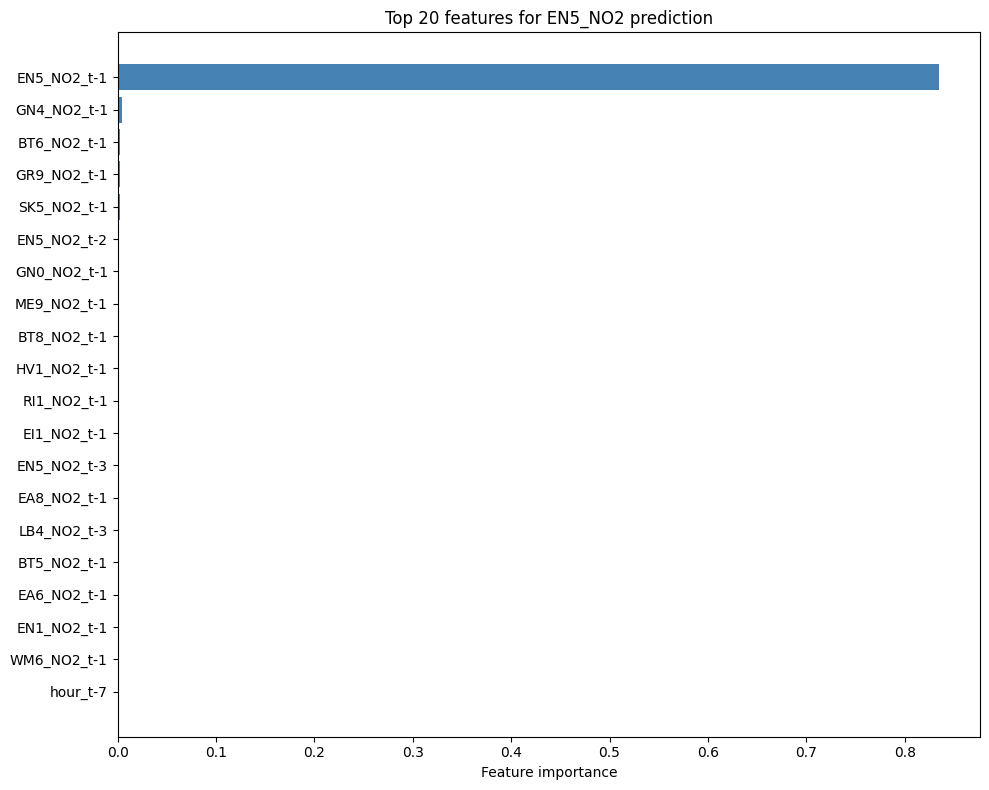


Figure saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/rf_model/feature_importance.png


In [49]:
# visualise top 20 features
fig, ax = plt.subplots(figsize=(10, 8))

top_20 = importance_df.head(20)
y_pos = range(len(top_20))

ax.barh(y_pos, top_20['importance'], color='steelblue')
ax.set_yticks(y_pos)
ax.set_yticklabels(top_20['feature'])
ax.invert_yaxis()  # highest at top
ax.set_xlabel('Feature importance')
ax.set_title(f'Top 20 features for {target_name} prediction')

plt.tight_layout()
plt.savefig(rf_output_dir / 'feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to: {rf_output_dir / 'feature_importance.png'}")

In [50]:
# analyse importance by category
print("Feature importance by category:")
print("-" * 40)

def categorise_feature(name):
    if 'hour' in name.lower():
        return 'temporal_hour'
    elif 'day' in name.lower():
        return 'temporal_day'
    elif 'month' in name.lower():
        return 'temporal_month'
    elif 'weekend' in name.lower():
        return 'temporal_weekend'
    elif 'NO2' in name:
        return 'NO2'
    elif 'PM10' in name:
        return 'PM10'
    elif 'O3' in name:
        return 'O3'
    else:
        return 'other'

importance_df['category'] = importance_df['feature'].apply(categorise_feature)

category_importance = importance_df.groupby('category')['importance'].sum().sort_values(ascending=False)

print(category_importance.to_string())
print(f"\nTotal importance: {category_importance.sum():.4f}")

Feature importance by category:
----------------------------------------
category
NO2                 0.956584
PM10                0.023567
O3                  0.012147
temporal_hour       0.006533
temporal_day        0.000695
temporal_month      0.000394
temporal_weekend    0.000079

Total importance: 1.0000


    Feature importance by category:
    ----------------------------------------
    category
    NO2                 0.956584
    PM10                0.023567
    O3                  0.012147
    temporal_hour       0.006533
    temporal_day        0.000695
    temporal_month      0.000394
    temporal_weekend    0.000079

    Total importance: 1.0000

### What the feature importance tells us

The analysis shows which inputs drive EN5_NO2 predictions:

**1. Same-station history dominates (EN5_NO2_t-1 = 83.5%)**

The previous hour's NO2 value at EN5 is by far the strongest predictor. This is strong temporal autocorrelation. NO2 levels change gradually, so the best predictor of next hour is the current hour.

**2. Other NO2 stations contribute weakly (total NO2 = 95.7%)**

GN4_NO2_t-1 (0.4%), BT6_NO2_t-1 (0.3%), GR9_NO2_t-1 (0.3%) etc. show weak spatial correlation. Nearby stations help slightly but not much.

**3. Cross-pollutant relationships are minimal**

| Pollutant | Importance |
| --- | --- |
| PM10 | 2.4% |
| O3 | 1.2% |

The pollutants are relatively independent. Knowing PM10 or O3 levels does not help much for predicting NO2.

**4. Temporal features barely matter (1.3% combined)**

| Feature | Importance |
| --- | --- |
| Hour of day | 0.7% |
| Day of week | 0.07% |
| Month | 0.04% |
| Weekend | 0.008% |

When pollution history is available, time features add little value. The model relies on autocorrelation rather than learning rush hour patterns directly.

**Interpretation for research:**

The model learns: next hour NO2 ≈ current hour NO2 + small adjustments. This is realistic but also limiting. The model struggles to predict sudden changes or pollution spikes that differ from recent history.


## 9) Prediction visualisation

Plotting actual vs predicted values helps identify systematic errors or patterns the model misses.

**Scatter plot interpretation:**
- Points close to the red line = good predictions
- Spread around the line shows prediction variance
- If points curve away at high values, model underestimates pollution spikes

**Time series interpretation:**
- Actual and predicted lines should follow similar patterns
- Gaps between lines show prediction errors
- Consistent lag suggests model needs more recent history

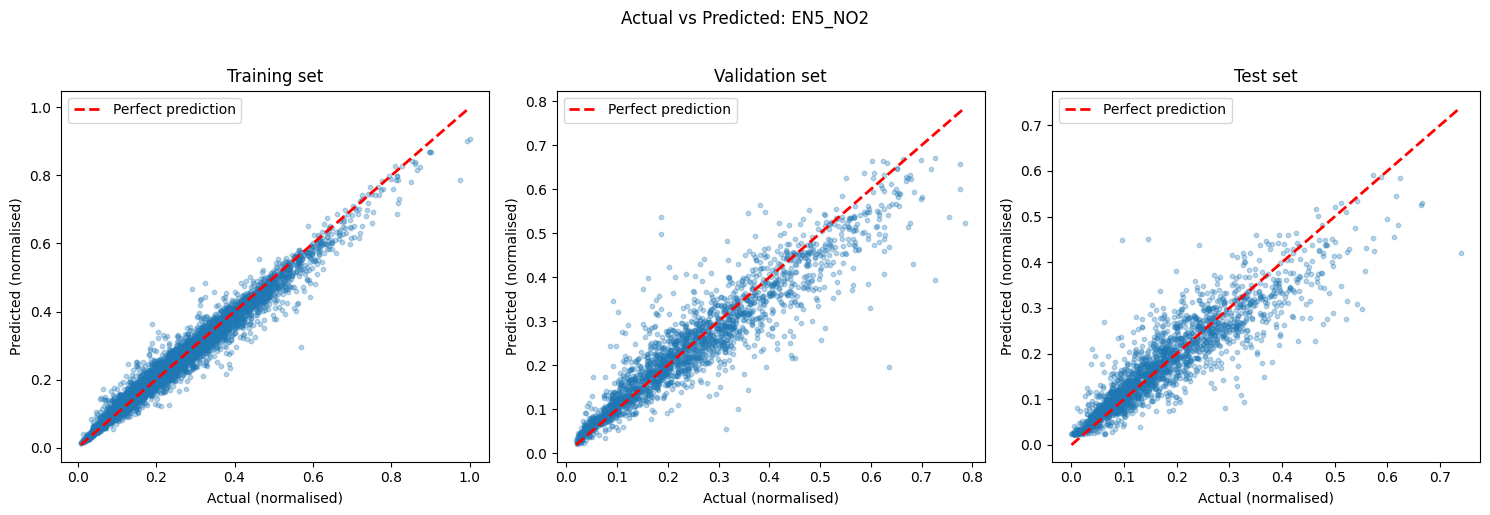

Figure saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/laqn/rf_model/actual_vs_predicted.png


In [51]:
# scatter plot actual vs predicted
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

datasets = [
    ('Training', y_train_single, tuned_train['y_pred']),
    ('Validation', y_val_single, tuned_val['y_pred']),
    ('Test', y_test_single, tuned_test['y_pred'])
]

for ax, (name, actual, predicted) in zip(axes, datasets):
    ax.scatter(actual, predicted, alpha=0.3, s=10)
    
    # perfect prediction line
    min_val = min(actual.min(), predicted.min())
    max_val = max(actual.max(), predicted.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
    
    ax.set_xlabel('Actual (normalised)')
    ax.set_ylabel('Predicted (normalised)')
    ax.set_title(f'{name} set')
    ax.legend()

plt.suptitle(f'Actual vs Predicted: {target_name}', y=1.02)
plt.tight_layout()
plt.savefig(rf_output_dir / 'actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Figure saved to: {rf_output_dir / 'actual_vs_predicted.png'}")